# Selective Style Transfer _ Team1
13146321 Hangbok Lee, 13146323 Minjae Cho, 15146326 Boyoung Han, 13146304 Jiwu Kim




# Motivation
Normally, style transfer is conducted with the whole picture like the below example.

<img src = "https://drive.google.com/uc?id=13RMkIm058p8jgmEZ1Nvyslnx9pAUvoyp">

If you give an input image and a style image, you can get an output image with the input style. We just wonder about would it be possible to change a specific object of the picture to another style? To get the specific part of the picture, we are going to use Semantic Segmentation. 

<img src = "https://drive.google.com/uc?id=1DebQCqO2NmGykrChr46JU3U30WI21XcL">

First, we need to find out the output of semantic segmentation and the input of style transfer. In order to change specific part of the picture, the output of semantic segmentation and input of style transfer format have to be same. Therefore, we are going to find each format of output and input and preprocess the output to match with the input. Finally, we can get a selectively style-transferred picture.


Below process shows the flow of our Selective Style Transfer and contains expected output picture. 

<img src = "https://drive.google.com/uc?id=104k-hfJnLuOrHXAf1vlyIzlWIOi-cLvF">



In [0]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from scipy.optimize import fmin_l_bfgs_b
import time
from keras import backend as K
import requests
from keras.applications import vgg19
from keras.preprocessing.image import img_to_array

Using TensorFlow backend.


# Semantic Segmentation

**First of all**, Let's use the model for semantic segmentation. For semantic segmentation there are various methodologies to solve. These multiple algorithms set compared data and indicators based on the performance of many benchmarks, pascal voc 2012 datasets often is being used. Algorithms, called as DeepLab, can seen in the top of the list. In this project, we used the most high performance deeplab. Below code is the model of DeepLab

In [0]:
class DeepLabModel(object):

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    self.graph = tf.Graph()

    graph_def = None
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  # In this part, we need to resize the image to match the size of ouput and input
  # The bigger size of image is, the longer time the processing needs
  def run(self, image):
   # width, height = image.size
    width = 300
    height= 300
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size  = width, height
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]

def vis_segmentation(image, seg_map):
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

As you can see `LABEL_NAMES`, This pretrained model can labele 15 objects including cat, dog, cow, sheep, and so on.

In [0]:
model_dir = tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
print('downloading model, this might take a while...')
urllib.request.urlretrieve('http://download.tensorflow.org/models/' + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)

downloading model, this might take a while...
download completed! loading DeepLab model...


For the style transfer, only the object image of the area cut through the semantic segmentation model above is required. The following function is **to cut down a recognized object.** This function get the `seg_map` as argument and cut the image in the way that ignoring RGB pixel in the location has value of Zero in 2D seg_map

In [0]:
def segement_image(img, seg_map):
  img_arr = np.array(img)
  for y in range(len(img_arr)):
    for x in range(len(img_arr[y])):
      if seg_map[y][x] > 0:
        continue
      else:
        img_arr[y][x] = (0, 0, 0)
  segmented_img = Image.fromarray(img_arr, 'RGB')
  return segmented_img

In this function, segmantic segmentation model is run. Then, this function will return image and seg map we need for style transfer only fit to recognized object.

In [0]:
def get_segmented_image(target_url, style_url):
  try:
    f_target = urllib.request.urlopen(target_url)
    f_style = urllib.request.urlopen(style_url)
    jpeg_str_target = f_target.read()
    jpeg_str_style = f_style.read()
    target_im = Image.open(BytesIO(jpeg_str_target))
    style_im = Image.open(BytesIO(jpeg_str_style))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + target_url)
    return

  print('running deeplab on image %s...' % target_url)

  resized_img, seg_map = MODEL.run(target_im)
  resized_img_style, seg_map_style = MODEL.run(style_im)

  segmented_img = segement_image(resized_img, seg_map)

  return segmented_img, resized_img, resized_img_style, seg_map

Now, put the target and style image and run the functions declared in above


In [0]:
TARGET_IMAGE_URL = 'https://drive.google.com/uc?id=1-HrIGvXXEIcVZ4GiJW0DwzYMXu3qr8kb'
STYLE_IMAGE_URL = 'https://drive.google.com/uc?id=1wR3liozaXRwEdnhWk8skK4zmy6-BH98u'

target_url = TARGET_IMAGE_URL 
style_url = STYLE_IMAGE_URL

target_img, original_img, style_img, seg_map = get_segmented_image(target_url, style_url)
img_width, img_height = target_img.size
style_img = style_img.resize((img_width, img_height))

running deeplab on image https://drive.google.com/uc?id=1-HrIGvXXEIcVZ4GiJW0DwzYMXu3qr8kb...


# Output Result

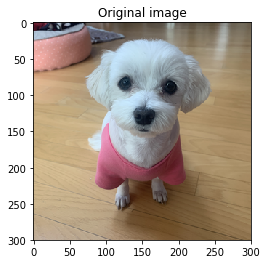

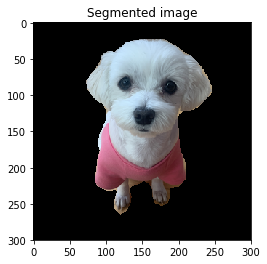

In [0]:
# show target and style
plt.imshow(original_img)
plt.title('Original image')
plt.show()
plt.imshow(target_img)
plt.title('Segmented image')
plt.show()

Above two graph shows the input image and segmented image.


# Style Transfer

As we had said in proposal, we used the pre-trained style-transfer network, "**VGG-19**". Although we also tried to utilize the "Resnet-50" network that designed in HW5, we excluded it because its transferring effect was relatively weak compared to the VGG-19. 

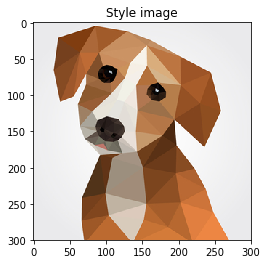

In [0]:
#show the style image
plt.imshow(style_img)
plt.title('Style image')
plt.show()

In [0]:
def load_image(image_url, img_width, img_height):
  response = requests.get(image_url)
  img = Image.open(BytesIO(response.content))
  img = img.resize((img_width, img_height))
  return img_to_array(img)

def preprocess_image(img):
  img = np.expand_dims(img, axis=0)
  img = vgg19.preprocess_input(img)
  return img

def deprocess_image(x):
  x[:,:,0] += 103.939
  x[:,:,1] += 116.779
  x[:,:,2] += 123.68
  x = x[:,:,::-1]
  x = np.clip(x, 0, 255).astype('uint8')
  return x

def content_loss(base, combination):
  return K.mean(K.square(combination - base))

def gram_matrix(x):
  features = K.batch_flatten(K.permute_dimensions(x, (2,0,1)))
  gram = K.dot(features, K.transpose(features))
  return gram

def style_loss(style, combination):
  S = gram_matrix(style)
  C = gram_matrix(combination)
  channels = 3
  size = img_height * img_width
  return K.mean(K.square(S - C))

def total_variation_loss(x):
  a = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
  b = K.square(
      x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
  return K.mean(K.pow(a + b, 1.25))

As we have learned in previous lectures, above functions are just for **Preprocessing Images** and **Calculating Loss**.

`load_image` loads content image to use in learning.

`preprocess_image` preprocesses an image before passing it to the network. In detail, it rescales from [0, 1] to [0, 255], converts from RGB to BGR, and subtracts the mean pixel.

`deprocess_image` is just the opposite function of preprocessing. [1]Scale Up, [2]rgb2bgr, and [3]Adding mean pixel.


Basically the process of calculating loss is, in other words, the construction process. Because it is activated using only one network, so the gradient of the input image could be obtained by having the input content A(a.k.a.Target) and the input style B(a.k.a.Style).

In [0]:
class Evaluator(object):

  def __init__(self):
    self.loss_value = None
    self.grads_values = None

  def loss(self, x):
    assert self.loss_value is None
    x = x.reshape((1, img_height, img_width, 3))
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1].flatten().astype('float64')
    self.loss_value = loss_value
    self.grad_values = grad_values
    return self.loss_value

  def grads(self, x):
    assert self.loss_value is not None
    grad_values = np.copy(self.grad_values)
    self.loss_value = None
    self.grad_values = None
    return grad_values

evaluator = Evaluator()

In [0]:
img_width, img_height = target_img.size

K.set_learning_phase(0)
target_image = preprocess_image(img_to_array(target_img))
target_image = K.constant(target_image)

style_img = style_img.resize((img_width, img_height))
style_reference_image = preprocess_image(img_to_array(style_img))
style_reference_image = K.constant(style_reference_image)

combination_image = K.placeholder((1, img_height, img_width, 3))

input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

model = vgg19.VGG19(input_tensor=input_tensor, 
                          weights='imagenet',
                          include_top=False)
model.summary()
print('Model loaded!')

W1215 06:44:19.644085 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1215 06:44:19.655191 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1215 06:44:19.660617 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1215 06:44:19.685379 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80150528/80134624 [==============================] - 2s 0us/step


W1215 06:44:22.802767 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1215 06:44:22.804296 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1215 06:44:22.806051 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.

W1215 06:44:22.807372 140500672694144 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:199: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.

W1215 06:44:22.875633 1405

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [0]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
content_layer = 'block5_conv2'
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.7
content_weight = 0.035

loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

W1215 06:44:23.280796 140500672694144 variables.py:2627] Variable += will be deprecated. Use variable.assign_add if you want assignment to the variable value or 'x = x + y' if you want a new python Tensor object.


In [0]:
grads = K.gradients(loss, combination_image)[0]
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

W1215 06:44:23.479168 140500672694144 deprecation.py:323] From /usr/local/lib/python2.7/dist-packages/tensorflow_core/python/ops/math_grad.py:1375: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
result_prefix = 'style_transfer_result'
iterations =5

x = preprocess_image(img_to_array(target_img))
x = x.flatten()
for i in range(iterations):
  print('Start of iteration', i)
  start_time = time.time()
  x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                   fprime=evaluator.grads, maxfun=20)
  print('Current loss value:', min_val)
  # Save current generated image
  img = x.copy().reshape((img_height, img_width, 3))
  img = deprocess_image(img)
  fname = result_prefix + '_at_iteration_%d.png' % i
  plt.imsave(fname, img)
  end_time = time.time()
  print('Image saved as', fname)
  print('Iteration %d completed in %ds' % (i, end_time - start_time))

('Start of iteration', 0)
('Current loss value:', 4.9393868e+16)
('Image saved as', 'style_transfer_result_at_iteration_0.png')
Iteration 0 completed in 181s
('Start of iteration', 1)
('Current loss value:', 3.7968404e+16)
('Image saved as', 'style_transfer_result_at_iteration_1.png')
Iteration 1 completed in 180s
('Start of iteration', 2)
('Current loss value:', 3.0898544e+16)
('Image saved as', 'style_transfer_result_at_iteration_2.png')
Iteration 2 completed in 180s
('Start of iteration', 3)
('Current loss value:', 2.5805315e+16)
('Image saved as', 'style_transfer_result_at_iteration_3.png')
Iteration 3 completed in 179s
('Start of iteration', 4)
('Current loss value:', 2.2025797e+16)
('Image saved as', 'style_transfer_result_at_iteration_4.png')
Iteration 4 completed in 180s


# Output Result

Simply, this transfer process takes place for the entire(original) image size which is received from previous semantic segmentation stage with black-colored background. So in this point, there is a need to **[1] exclude those meaningless background** to extract only segmented object and then **[2] combine its object** with the background of original image.

Through below code, we could get final output of our selective style transfer.

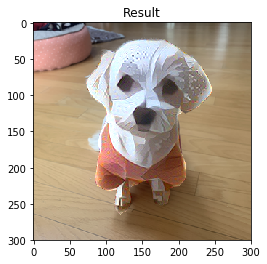

In [0]:
original_arr = np.array(original_img)

for y in range(len(original_arr)):
  for x in range(len(original_arr[y])):
    if seg_map[y][x] > 0:
      original_arr[y][x] = img[y][x]
result = Image.fromarray(original_arr, 'RGB')

plt.imshow(result)
plt.title("Result")
plt.show()

# Final Results

The final results are like below pictures.

<img src = "https://drive.google.com/uc?id=1QoCHryuJG3EiMibN8KRZMsqhkBovPzke">

Below results are with people.

<img src = "https://drive.google.com/uc?id=1tpV28vf6UjxgaHCLv9nFiSmLcLJzWdbt">


We tried with several people, but as you can see below, there are kinda weird, scary and seem like Uncanny Valley. Semantic segmentation is worked well for the people, but style transfer is not. Therefore, we decided to exclude the result of people for a survey.

# Survey 

We conducted a survey through 30 persons about our style transfer.

The questions are like below : According to the picture as provided,
1. Can recognize that the background of the photo and the style of the subject are different.
2. The subject was well trained like a style image (no 1 / yes 6)

Survey pictures and results are like below : 

**Dog**


<img src = "https://drive.google.com/uc?id=1Y0KS-cKPYV8LtIP1sv5lfr_Ph7bxy3Jw">

*Result*

Q1. Can recognize that the background of the photo and the style of the subject are different.
<img src="https://drive.google.com/uc?id=1jqg2YSm__XXyI_6SXkcT1JrolmSfOCDU">

Q2. The subject was well trained like a style image (no 1 / yes 6)
<img src="https://drive.google.com/uc?id=1qKRXnxakaMvYluCqrO7r-ajtbCDNpVuu">

**Cat**

*Pictures*

<img src = "https://drive.google.com/uc?id=1UQBPAhbLMxnqfK9rZfjWpT7zJQ2vCFa7">

*Result*

Q1. Can recognize that the background of the photo and the style of the subject are different.
<img src="https://drive.google.com/uc?id=1I5Gw9uPPGfjRU1ZEjUwR4hW6twSNt3T2">

Q2. The subject was well trained like a style image (no 1 / yes 6)
<img src="https://drive.google.com/uc?id=1K1kTZzzlBqOiKnrjA776ncUReqr23aB5">


**Horse**

<img src = "https://drive.google.com/uc?id=13HLXtS4d4FVqi3ig_bV65urSAMaG8tOg">

*Result*

Q1. Can recognize that the background of the photo and the style of the subject are different.
<img src="https://drive.google.com/uc?id=1XAY-qkuchyr7Or8NwVtuUXIXCcFt6q_i">

Q2. The subject was well trained like a style image (no 1 / yes 6)
<img src="https://drive.google.com/uc?id=1gOhjVp839LTG28_cHDyjVZLI4HxaHrVs">

**Sheep**

<img src = "https://drive.google.com/uc?id=1GNdEiIYc_x-Cm8LMNAQRyhkerSFPnxHr">

*Result*

Q1. Can recognize that the background of the photo and the style of the subject are different.
<img src="https://drive.google.com/uc?id=1-FlBKGNDuT2_Z1f-EIpWORnXoGNUWHec">

Q2.The subject was well trained like a style image (no 1 / yes 6)
<img src="https://drive.google.com/uc?id=1QEnzOQ6vALLcAmBzO39X6nEW5gslnCwk">


**Cow**

<img src = "https://drive.google.com/uc?id=1xRr1lPCZCLd_-OIOUJFQTyTb9oyV7vq3">


*Result*

Q1. Can recognize that the background of the photo and the style of the subject are different.
<img src="https://drive.google.com/uc?id=1jjRnxJv93eRQm36vnf45MqitHJ15rJoj">

Q2. The subject was well trained like a style image (no 1 / yes 6)
<img src="https://drive.google.com/uc?id=1YThiSThXUfx0mDsLYeglLWyR5ZoNfLS-">

# References
[1] Liang-Chieh, C., Yukun, Z., George, P., Florian, S., & Hartwig, A. (2018). Encoder-Decoder with Artrous Separable Convolution for Semantic Image Segmentation. ArXiv, abs/1802.02611.

[2] Leon A. Gatys, Alexander S. Ecker, & Matthias B. (2016). Image Style Transfer Using Convolutional Neural Networks. 

[3] Yeh, M., Tang, S., Bhattad, A., & Forsyth, D.A. (2018). Quantitative Evaluation of Style Transfer. ArXiv, abs/1804.00118.

[4] https://github.com/jfzhang95/pytorch-deeplab-xception

[5] https://github.com/bonlime/keras-deeplab-v3-plus

[6] Yang, K., Lee, J., & Wang, J. Semantic Segmented Style Transfer.

[7] https://blog.lunit.io/2018/07/02/deeplab-v3-encoder-decoder-with-atrous-separable-convolution-for-semantic-image-segmentation/


#File Storage

You can get input image, style image, result of our project through below google drive address. 

https://drive.google.com/open?id=1XMeftlhKagL5SNY36aW84OEwwXathrxL

# Contribution statement(Total : 100)

13146321 Hangbok Lee : Programming, Make Questionaire (30)

13146323 Minjae Cho : Programming, Documentation (30)

15146326 Boyoung Han : Data collection, Presentation (30)

13146304 Jiwu Kim : Supporter (10)